**Текст задания:**
1. **А/В тестирование**   
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.   

2. **SQL**   
2.1 *Очень усердные ученики*.   
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.   
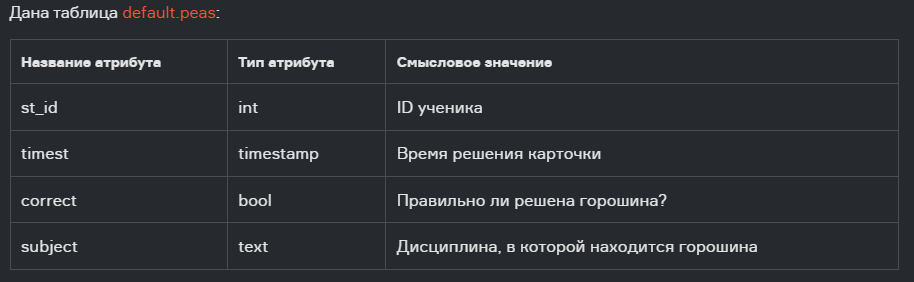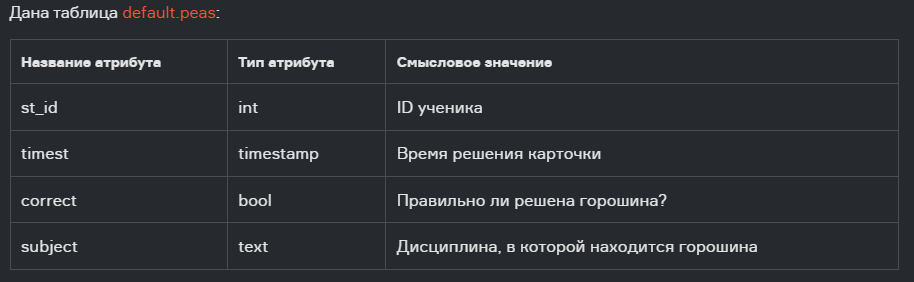   
2.2 *Оптимизация воронки*   
Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.   
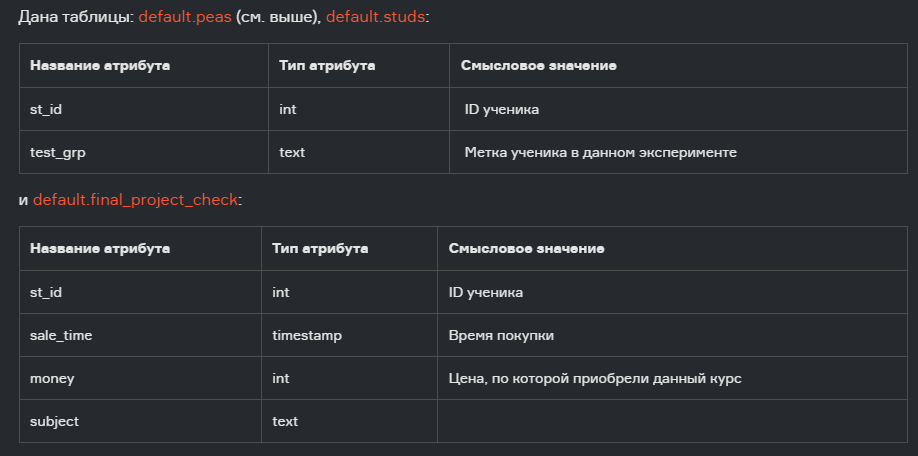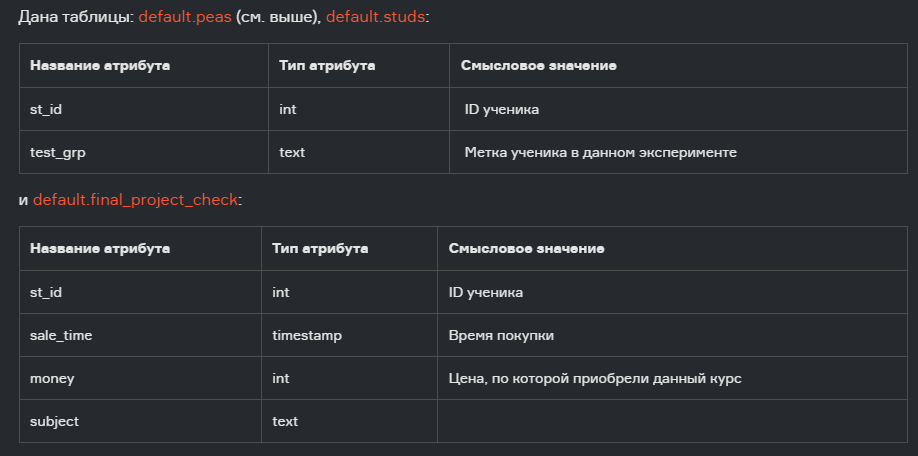   
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
+ ARPU 
+ ARPAU 
+ CR в покупку 
+ СR активного пользователя в покупку 
+ CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
+ ARPU считается относительно всех пользователей, попавших в группы.   
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.   
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.   
3. Python   
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.   
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

**Описание данных:**   
+ groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
+ groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
+ active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
+ checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

# 1 задание. A/B-тестирование
## Загрузка данных, EDA и предобработка

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as st
import pingouin as pg
import numpy as np

import requests 
import urllib
import json
from urllib.parse import urlencode 

Реализуем функцию для считывания файлов с яндекс.диска

In [2]:
def get_ya_disk(public_key):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = public_key

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    return download_url

In [3]:
groups = pd.read_csv(get_ya_disk('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


Посмотрим на процент отсутствующих значений в таблице с группами, соотношение групп и общее количество студентов

In [5]:
print('Процент отсутствующих значений по колонкам:', groups.isna().mean(), sep='\n')
print('\nУникальных айди:', groups['id'].nunique())
print('\nКоличество студентов по группам:', groups['grp'].value_counts(), sep='\n')
print('\nПроцентное соотношение групп:', groups['grp'].value_counts(normalize=True), sep='\n')

Процент отсутствующих значений по колонкам:
id     0.0
grp    0.0
dtype: float64

Уникальных айди: 74484

Количество студентов по группам:
B    59813
A    14671
Name: grp, dtype: int64

Процентное соотношение групп:
B    0.803032
A    0.196968
Name: grp, dtype: float64


In [6]:
groups_add = pd.read_csv(get_ya_disk('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'))
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


Посмотрим на этом датафрейме то же самое, что и на предыдущем, а также, есть ли повторяющиеся айди в этих двух датафреймах

In [7]:
print('Процент отсутствующих значений по колонкам:', groups.isna().mean(), sep='\n')
print('\nУникальных айди:', groups_add['id'].nunique())
print('\nКоличество студентов по группам:', groups_add['grp'].value_counts(), sep='\n')
print('\nПроцентное соотношение групп:', groups_add['grp'].value_counts(normalize=True), sep='\n')
print('\nКоличество пересекающихся айди:', groups_add['id'].isin(groups['id']).sum())

Процент отсутствующих значений по колонкам:
id     0.0
grp    0.0
dtype: float64

Уникальных айди: 92

Количество студентов по группам:
B    70
A    22
Name: grp, dtype: int64

Процентное соотношение групп:
B    0.76087
A    0.23913
Name: grp, dtype: float64

Количество пересекающихся айди: 0


Можно склеить два эти датафрейма - второй просто дополняет первый

In [8]:
groups_full = pd.concat([groups, groups_add])
groups_full

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [9]:
active_studs = pd.read_csv(get_ya_disk('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


На этом датафрейме важно проверить количество уникальных айди и пропущенные значения.   
Предыдущий датафрейм представляет собой разделение всех пользователей на две группы. Этот датафрейм содержит только тех пользователей, которые приняли участие в эксперименте. Поэтому также нужно проверить, что для каждого из них определена группа.

In [10]:
print('Процент отсутствующих значений:', active_studs.isna().mean(), sep='\n')
print('\nУникальных айди:', active_studs['student_id'].nunique())
print('\nКоличество студентов, группа которых определена:', active_studs['student_id'].isin(groups_full['id']).sum())

Процент отсутствующих значений:
student_id    0.0
dtype: float64

Уникальных айди: 8341

Количество студентов, группа которых определена: 8341


In [11]:
checks = pd.read_csv(get_ya_disk('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


Этот датафрейм содержит айди студента и сумму чека.   
Посмотрим количество уникальных платящих пользователей, отсутствующие значения, все ли эти айди есть в таблице активных пользователей (а так же, для всех ли айди из этой таблицы определена группа), а также распределение сумм чеков

In [12]:
print('Процент отсутствующих значений:', checks.isna().mean(), sep='\n')
print('\nУникальных айди:', checks['student_id'].nunique())
print('\nКоличество активных студентов:', checks['student_id'].isin(active_studs['student_id']).sum())
print('\nКоличество студентов, группа которых определена:', checks['student_id'].isin(groups_full['id']).sum())

Процент отсутствующих значений:
student_id    0.0
rev           0.0
dtype: float64

Уникальных айди: 541

Количество активных студентов: 392

Количество студентов, группа которых определена: 541


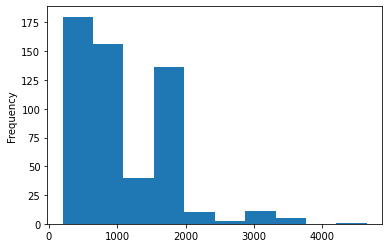

In [13]:
checks['rev'].plot(kind='hist')

Во-первых, видно, что большая часть студентов заплатила в пределах 2000 р, абсолютное большинство заплатило в переделах 4000 р, при этом есть небольшие выбросы >4000 р.   
Во-вторых, что самое интересное, не все студенты, совершившие покупку в период эксперимента, заходили при этом на платформу.   
У этого может быть несколько причин:   
1. для оплаты услуг не обязательно заходить на сайт
2. могут быть проблемы с отслеживанием активности на сайте   
3. автооплата

Теперь переджойним все таблицы, чтобы иметь всю информацию в одном датафрейме
Для начала добавим колонку с активностью студента, чтобы не потерять информацию об этом при джойне

In [14]:
active_studs['is_active'] = 1

In [15]:
groups_full.rename(columns={'id': 'student_id'}, inplace=True)

In [16]:
test_data = groups_full.merge(active_studs, on='student_id', how='left').merge(checks, on='student_id', how='left')
test_data

,student_id,grp,is_active,rev
0,1489,B,NaN,NaN
1,1627,A,1.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN
...,...,...,...,...
74571,200247820,B,NaN,NaN
74572,201032527,B,NaN,NaN
74573,201067612,B,NaN,NaN
74574,201067653,B,NaN,NaN


Проверим, правильно ли сджойнились эти таблицы:   
В файле groups_full 74576 студентов.   
Активных - 8341. Соответственно, 74 576 - 8 341 = 66 235 неактивных.   
Платящих - 541. Соответственно, 74 576 - 541 = 74 035 неплатящих.

In [17]:
print('Уникальных айди:', test_data['student_id'].nunique())
print('Неактивных:', test_data.is_active.isna().sum())
print('Неплатящих:', test_data.rev.isna().sum())

Уникальных айди: 74576
Неактивных: 66235
Неплатящих: 74035


Все совпадает. Теперь заполним отсутствующе значения в столбце rev нулями - эти студенты ничего не покупали в период проведения тестирования и сджойним эту таблицу с таблицей разбиения на группы.    
Также заполним нулями Nan в is_active - эти пользователи не были активны

In [18]:
test_data.rev = test_data.rev.fillna(0)
test_data.is_active = test_data.is_active.fillna(0)
test_data

,student_id,grp,is_active,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0
...,...,...,...,...
74571,200247820,B,0.0,0.0
74572,201032527,B,0.0,0.0
74573,201067612,B,0.0,0.0
74574,201067653,B,0.0,0.0


## Еще раз посмотрим на данные

Посмотрим общую сумму покупок, средний чек по всем пользователям и количество пользователей по группам

In [19]:
test_data.groupby('grp')['rev'].agg(['sum', 'mean', 'count'])

,sum,mean,count
grp,,,
A,92096.0000,6.268019,14693
B,481230.0036,8.036171,59883


Видно, что у нас сильный дисбаланс групп - в группе Б в 4,5 раза больше студентов. Этим объясняется разница в общей сумме покупок    
Посмотрим статистику только по студентам, которые в этот период оплатили услуги

In [20]:
test_data[test_data['rev'] != 0].groupby('grp')['rev'].agg(['sum', 'mean', 'count'])

,sum,mean,count
grp,,,
A,92096.0000,860.710280,107
B,481230.0036,1108.824893,434


Посмотрим на разницу распределений сумм покупок по группам

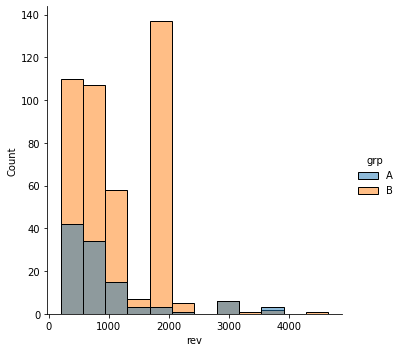

In [21]:
sns.displot(data=test_data[test_data.rev != 0], x='rev', hue='grp')

Несмотря на разницу в количестве студентов, общие распределения выглядят похоже, за исключением того, что в группе B гораздо больше доля студентов, заплативших около 2000.

## Метрики   
В первую очередь приходит в голову ARPU - его обязательно стоит проверить, потому что если новая система оплаты удобнее для пользователей, логично предположить, что пользоваться ей будут чаще. А заодно посмотрим и ARPPU.
Вторая метрика - доля пользователей, совершивших покупку, иначе говоря, конверсия в покупку в этот период.

### Конверсия   
Для тестирования, есть ли разница в конверсии будем использовать типичный для этой метрики способ - Хи-квадрат   
Для удобства создания таблицы сопряженности добавим в таблицу еще один столбец, который будет показывать, сконвертировался ли студент

In [22]:
test_data['is_conv'] = test_data['rev'].apply(lambda x: 1 if x > 0 else 0)
test_data

,student_id,grp,is_active,rev,is_conv
0,1489,B,0.0,0.0,0
1,1627,A,1.0,990.0,1
2,1768,B,0.0,0.0,0
3,1783,B,0.0,0.0,0
4,1794,A,0.0,0.0,0
...,...,...,...,...,...
74571,200247820,B,0.0,0.0,0
74572,201032527,B,0.0,0.0,0
74573,201067612,B,0.0,0.0,0
74574,201067653,B,0.0,0.0,0


Стороим таблицу сопряженности

In [23]:
conv_cross = pd.crosstab(index=test_data.is_conv, columns=test_data.grp)
conv_cross

grp,A,B
is_conv,,
0,14586,59449
1,107,434


В кросстабе видно знакомые значения - 107 платящих студентов в группе A и 434 - в группе B. Те же цифры мы видели при изучении данных, значит, кросстаб построен правильно   
Из него уже видно, что особых различий в конверсии между группами нет - обе строчки отличаются примерно в одной и той же пропорции. Но на всякий случай проверим   
Во всех ячейках достаточно много данных - это значит, нам нужен обычный Хи-квадрат - точный критерий Фишера и Хи-квадрат с поправкой Йетса отпадают.

In [24]:
st.chi2_contingency(conv_cross)

(0.0,
 1.0,
 1,
 array([[14586.41191536, 59448.58808464],
        [  106.58808464,   434.41191536]]))

Pvalue идет в массиве второй, значит с индексом 1. Посмотрим на него отдельно

In [25]:
st.chi2_contingency(conv_cross)[1]

1.0

Pvalue очень большой - мы не можем отвергнуть нулевую гипотезу, которая в случае Хи-квадрат предполагает, что различий между группами нет   

### ARPU и ARPPU
На нормальность распределения проверять нет необходимости - мы уже видим, что нормальными они не являются

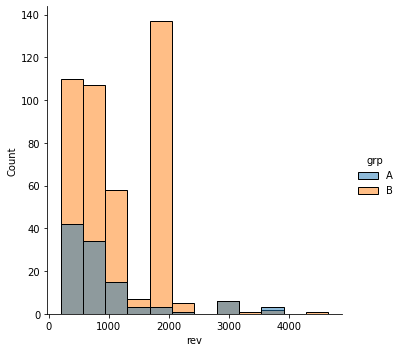

In [26]:
sns.displot(data=test_data[test_data.rev != 0], x='rev', hue='grp')

На всякий случай взглянем на qq-plot

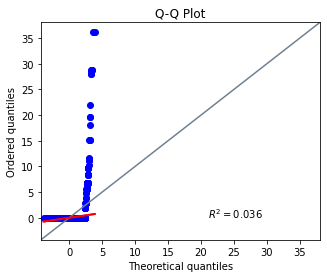

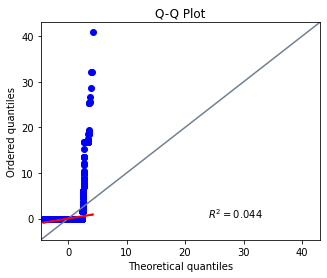

In [27]:
pg.qqplot(x=test_data[test_data['grp'] == 'A']['rev'])
pg.qqplot(x=test_data[test_data['grp'] == 'B']['rev'])

Даже не близко.   
Определимся с тестами. При континуальной переменной мы можем использовать много тестов, но наилучши вариантом будет бутстрап - Т-тест сильно потеряет в точности из-за ненормальности, а критерий Манна-Уитни не сравнивает средние.

Сначала подготовим данные - сделаем два массива, по суммам покупок групп А и Б - для ARPU, и еще два массива по группам, но только из платящих пользователей - для ARPPU

In [28]:
rev_group_A = test_data[test_data.grp == 'A'].rev
rev_group_B = test_data[test_data.grp == 'B'].rev

rev_group_A_paying = test_data[(test_data.grp == 'A') & (test_data.rev > 0)].rev
rev_group_B_paying = test_data[(test_data.grp == 'B') & (test_data.rev > 0)].rev

Сначала посмотрим ARPU

In [29]:
pg.compute_bootci(x=rev_group_A, func='mean', paired=False, confidence=0.95, seed=42)

array([4.73, 7.99])

In [30]:
pg.compute_bootci(x=rev_group_B, func='mean', paired=False, confidence=0.95, seed=42)

array([7.18, 9.02])

Как видно, доверительные интервалы пересекаются - значит, нулевую гипотезу об отсутствии различий отвергнуть мы не можем   
Теперь посмотрим ARPPU

In [31]:
pg.compute_bootci(x=rev_group_A_paying, func='mean', paired=False, confidence=0.95, seed=42)

array([ 715.09, 1030.94])

In [32]:
pg.compute_bootci(x=rev_group_B_paying, func='mean', paired=False, confidence=0.95, seed=42)

array([1039.25, 1179.  ])

Мы видим, что доверительные интервалы не пересекаются - между средними значениями выборок есть статистически значимая разница, при этом среднее группы B больше.
Таким образом,       
1. Мы можем отвергнуть нулевую гипотезу об отсутствии различий в ARPPU этих выборок
2. Мы не можем отвергнуть нулевые гипотезы об отсутствии различий в ARPU и конверсии выборок   

Тем не менее, ARPPU статистически значимо вырос.

А значит, ***запускаем новую систему оплаты на всех пользователей***

# 2 задание. SQL

## 2.1 Очень усердные ученики

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.   
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.


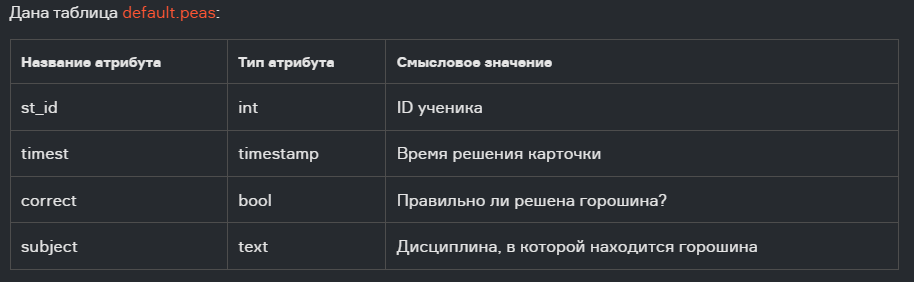

In [ ]:
query = '''
SELECT COUNT(DISTINCT sq1.st_id) AS very_diligent_students_count   
FROM    
    (SELECT st_id, COUNT(correct) AS correct_peas   
    FROM default.peas   
    WHERE    
        correct = TRUE    
        AND   
        toStartOfMonth(timest::DATE) = toStartOfMonth(now()::DATE)   
    GROUP BY st_id) AS sq1   
WHERE    
    correct_peas >= 20   
'''

## 2.2 Оптимизация воронки

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

1. ARPU    
2. ARPAU    
3. CR в покупку    
4. СR активного пользователя в покупку    
5. CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике   
6. ARPU считается относительно всех пользователей, попавших в группы.   

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

![Opera Снимок_2023-09-27_204958_lab.karpov.courses.png](<attachment:Opera Снимок_2023-09-27_204958_lab.karpov.courses.png>)
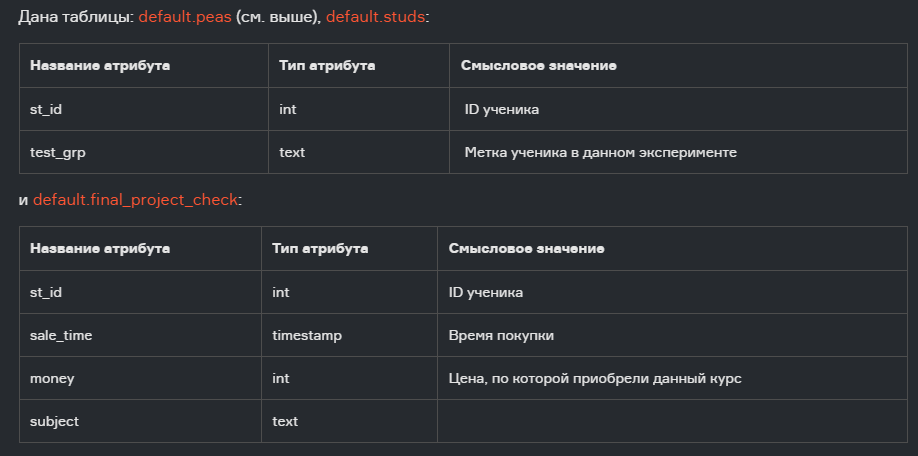

Соберем этот запрос по частям   
В первом CTE соберем айди студентов и флаги - активен ли студент вообще и по математике, используя таблицу default.peas

In [1]:
query = '''
WITH activity_table AS
    (SELECT 
        st_id, 
        CASE WHEN COUNT(correct) FILTER(WHERE correct = true)  > 10 THEN 1 ELSE 0 END AS is_active,
        CASE WHEN COUNT(correct) FILTER(WHERE correct = true AND subject = 'math') > 2 THEN 1 ELSE 0 END AS is_math_active
    FROM default.peas
    GROUP BY st_id)
'''  

Во втором CTE соберем айди студентов, сумму их покупок курсов и флаг, покупал ли студент курс по математике, используя таблицу default.final_project_check

In [ ]:
query = '''
money_math_table AS 
    (SELECT st_id, 
        SUM(money) AS total_money,
        MAX(CASE WHEN subject = 'math' THEN 1 ELSE 0 END) AS bought_math_course
    FROM default.final_project_check
    GROUP BY st_id)
'''

Информация из двух таблиц отобрана и сгруппирована по айди студентов. Третьей таблице, default.studs, группировка не нужна - она содержит только айди студента и его метку в эксперименте. Значит, можно написать итоговый запрос:

In [ ]:
query = '''
WITH activity_table AS
    (SELECT 
        st_id, 
        CASE WHEN COUNT(correct) FILTER(WHERE correct = true)  > 10 THEN 1 ELSE 0 END AS is_active,
        CASE WHEN COUNT(correct) FILTER(WHERE correct = true AND subject = 'math') > 2 THEN 1 ELSE 0 END AS is_math_active
    FROM default.peas
    GROUP BY st_id),
    
money_math_table AS 
    (SELECT st_id, 
        SUM(money) AS total_money,
        MAX(CASE WHEN subject = 'math' THEN 1 ELSE 0 END) AS bought_math_course
    FROM default.final_project_check
    GROUP BY st_id)

SELECT test_grp,
    SUM(total_money) / COUNT(a.st_id) AS ARPU,
    SUM(total_money) / COUNT(a.st_id) FILTER(WHERE is_active = 1) AS ARPAU,
    COUNT(a.st_id) FILTER(WHERE total_money > 0) / COUNT(a.st_id) AS CR,
    COUNT(a.st_id) FILTER(WHERE total_money > 0 AND is_active = 1) / COUNT(a.st_id) FILTER(WHERE is_active = 1) AS CR_active,
    COUNT(a.st_id) FILTER(WHERE is_math_active = 1 AND bought_math_course = 1) / COUNT(a.st_id) FILTER(WHERE is_math_active = 1) AS CR_active_math
FROM default.studs a 
    LEFT JOIN activity_table b ON a.st_id = b.st_id
    LEFT JOIN money_math_table c ON a.st_id = c.st_id
GROUP BY test_grp
'''

# Задание 3. Функции

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.   


Допустим, в файле будут не только id студента и группа, как это было в файле для задания с таким же названием, а еще и информация о совершенных покупках - иначе пересчитать метрики не получится.    
Соответственно, ожидаемо, что дополнительный файл имеет такую структуру - student_id, rev, grp

Так как предполагается, что файл будет обновляться, для начала добавим колонку итерации в начальный датафрейм - чтобы понимать, из какого обновления та или иная строчка

In [33]:
test_data['iteration'] = test_data.student_id.isin(groups_add.id).astype(int)
test_data

,student_id,grp,is_active,rev,is_conv,iteration
0,1489,B,0.0,0.0,0,0
1,1627,A,1.0,990.0,1,0
2,1768,B,0.0,0.0,0,0
3,1783,B,0.0,0.0,0,0
4,1794,A,0.0,0.0,0,0
...,...,...,...,...,...,...
74571,200247820,B,0.0,0.0,0,1
74572,201032527,B,0.0,0.0,0,1
74573,201067612,B,0.0,0.0,0,1
74574,201067653,B,0.0,0.0,0,1


In [34]:
test_data

,student_id,grp,is_active,rev,is_conv,iteration
0,1489,B,0.0,0.0,0,0
1,1627,A,1.0,990.0,1,0
2,1768,B,0.0,0.0,0,0
3,1783,B,0.0,0.0,0,0
4,1794,A,0.0,0.0,0,0
...,...,...,...,...,...,...
74571,200247820,B,0.0,0.0,0,1
74572,201032527,B,0.0,0.0,0,1
74573,201067612,B,0.0,0.0,0,1
74574,201067653,B,0.0,0.0,0,1


В новом файле groups_add заголовки могут отличаться - напишем функцию, исправляющую это

In [35]:
def make_headers_great_again(groups_add):
    for col_name in groups_add.columns:
        if groups_add.col_name.iloc[0].isnum():
            groups_add.rename(columns={name: 'student_id'})
        if groups_add.col_name.iloc[0].isalpha():
            groups_add.rename(columns={name: 'grp'})
            
    return groups_add[['student_id', 'grp']]

Зададим датафрейм с матриками, который будем обновлять на основе новых данных, после чего на основе проделанных операций напишем функцию, которая будет создавать строчку с пересчитанными метриками при добавлении итерации   
Зададим датафрейм с номером итерации и посчитанной конверсией по группам

In [36]:
metrics = test_data[test_data.iteration == 0].groupby(['grp'], as_index=False)['is_conv'].agg('mean').assign(iteration=0) \
            .pivot(columns='grp', values='is_conv', index='iteration').reset_index() \
            .rename(columns={'A': 'CR_A', 'B': 'CR_B'})
metrics

grp,iteration,CR_A,CR_B
0,0,0.007293,0.007239


Добавим Pvalue конверсии, посчитанное методом Хи-квадрат

In [37]:
metrics['CR_Pvalue'] = st.chi2_contingency(pd.crosstab(index=test_data[test_data.iteration == 0].is_conv, 
                                                       columns=test_data[test_data.iteration == 0].grp))[1]
metrics

grp,iteration,CR_A,CR_B,CR_Pvalue
0,0,0.007293,0.007239,0.988128


На очереди ARPU

In [38]:
metrics['ARPU_A'] = test_data[(test_data.iteration==0) & (test_data.grp=='A')].rev.agg('mean')
metrics['ARPU_B'] = test_data[(test_data.iteration==0) & (test_data.grp=='B')].rev.agg('mean')
metrics

grp,iteration,CR_A,CR_B,CR_Pvalue,ARPU_A,ARPU_B
0,0,0.007293,0.007239,0.988128,6.277418,8.01381


Так как для анализа мы использовали бутстрап, а в нем нас интересует не Pvalue, а пересекаются ли доверительные интервалы, добавим колонку, в которой будет содержатся True или False - пересекаются ли они

In [39]:
boot_res_arpu_A = pg.compute_bootci(x=test_data[(test_data.iteration == 0) & (test_data.grp == 'A')].rev,
                                    func='mean', paired=False, confidence=0.95, seed=42)
boot_res_arpu_B = pg.compute_bootci(x=test_data[(test_data.iteration == 0) & (test_data.grp == 'B')].rev, 
                                   func='mean', paired=False, confidence=0.95, seed=42)

metrics['ARPU_is_significant'] = (boot_res_arpu_A[0] > boot_res_arpu_B[1]) | \
    (boot_res_arpu_B[0] > boot_res_arpu_A[1])
       
metrics

grp,iteration,CR_A,CR_B,CR_Pvalue,ARPU_A,ARPU_B,ARPU_is_significant
0,0,0.007293,0.007239,0.988128,6.277418,8.01381,False


Проделаем то же самое с ARPPU

In [40]:
metrics['ARPPU_A'] = test_data[(test_data.iteration==0) & (test_data.grp=='A') & (test_data.rev > 0)].rev.agg('mean')
metrics['ARPPU_B'] = test_data[(test_data.iteration==0) & (test_data.grp=='B') & (test_data.rev > 0)].rev.agg('mean')
metrics

grp,iteration,CR_A,CR_B,CR_Pvalue,ARPU_A,ARPU_B,ARPU_is_significant,ARPPU_A,ARPPU_B
0,0,0.007293,0.007239,0.988128,6.277418,8.01381,False,860.71028,1106.997699


In [41]:
boot_res_arppu_A = pg.compute_bootci(x=test_data[(test_data.iteration == 0) & (test_data.grp == 'A') & (test_data.rev > 0)].rev, 
                                     func='mean', paired=False, confidence=0.95, seed=42)

boot_res_arppu_B = pg.compute_bootci(x=test_data[(test_data.iteration == 0) & (test_data.grp == 'B') & (test_data.rev > 0)].rev,
                                     func='mean', paired=False, confidence=0.95, seed=42)

metrics['ARPPU_is_significant'] = (boot_res_arppu_A[0] > boot_res_arppu_B[1]) | \
    (boot_res_arppu_B[0] > boot_res_arppu_A[1])
       
metrics

grp,iteration,CR_A,CR_B,CR_Pvalue,ARPU_A,ARPU_B,ARPU_is_significant,ARPPU_A,ARPPU_B,ARPPU_is_significant
0,0,0.007293,0.007239,0.988128,6.277418,8.01381,False,860.71028,1106.997699,True


In [42]:
metrics

grp,iteration,CR_A,CR_B,CR_Pvalue,ARPU_A,ARPU_B,ARPU_is_significant,ARPPU_A,ARPPU_B,ARPPU_is_significant
0,0,0.007293,0.007239,0.988128,6.277418,8.01381,False,860.71028,1106.997699,True


Соберем все проделанные шаги в функцию

In [43]:
def update_metrics(data=test_data, metrics_data=metrics):
    res = data.groupby(['grp'], as_index=False)['is_conv'].agg('mean').assign(iteration=data.iteration.max()) \
            .pivot(columns='grp', values='is_conv', index='iteration').reset_index() \
            .rename(columns={'A': 'CR_A', 'B': 'CR_B'})
    res['CR_Pvalue'] = st.chi2_contingency(pd.crosstab(index=data.is_conv, columns=data.grp))[1]
    
    res['ARPU_A'] = data[data.grp=='A'].rev.agg('mean')
    res['ARPU_B'] = data[data.grp=='B'].rev.agg('mean')
    
    boot_arpu_A = pg.compute_bootci(x=data[data.grp == 'A'].rev, func='mean', paired=False, confidence=0.95, seed=42)
    boot_arpu_B = pg.compute_bootci(x=data[data.grp == 'B'].rev, func='mean', paired=False, confidence=0.95, seed=42)

    res['ARPU_is_significant'] = (boot_arpu_A[0] > boot_arpu_B[1]) | \
    (boot_arpu_B[0] > boot_arpu_A[1])
    
    res['ARPPU_A'] = data[(data.grp=='A') & (data.rev > 0)].rev.agg('mean')
    res['ARPPU_B'] = data[(data.grp=='B') & (data.rev > 0)].rev.agg('mean')
    
    boot_arppu_A = pg.compute_bootci(x=data[(data.grp == 'A') & (data.rev > 0)].rev,
                                func='mean', paired=False, confidence=0.95, seed=42)

    boot_arppu_B = pg.compute_bootci(x=data[(data.grp == 'B') & (data.rev > 0)].rev,
                                func='mean', paired=False, confidence=0.95, seed=42)

    res['ARPPU_is_significant'] = (boot_arppu_A[0] > boot_arppu_B[1]) | \
    (boot_arppu_B[0] > boot_arppu_A[1])
    
    return pd.concat([metrics_data, res])

In [44]:
metrics = update_metrics(data=test_data, metrics_data=metrics)

In [45]:
metrics

grp,iteration,CR_A,CR_B,CR_Pvalue,ARPU_A,ARPU_B,ARPU_is_significant,ARPPU_A,ARPPU_B,ARPPU_is_significant
0,0,0.007293,0.007239,0.988128,6.277418,8.013810,False,860.71028,1106.997699,True
0,1,0.007282,0.007247,1.000000,6.268019,8.036171,False,860.71028,1108.824893,True


Теперь соберем это в функцию считывания, обработки и обновления метрик

In [46]:
def get_new_data(file_link, test_data=test_data, metrics_data=metrics):
    add_data = pd.read_csv(get_ya_disk(file_link))
    add_data = make_headers_great_again(add_data)
    
    test_data = pd.concat([groups_full, add_data]).merge(checks, on='student_id', how='left') \
                            .merge(active_studs, on='student_id', how='left')
    test_data.is_conv = add_data.rev.apply(lambda x: 1 if x > 0 else 0)
    test_data.iteration = test_data.iteration.max() + 1
    
    test_data = pd.concat([test_data, add_data])
    
    metrics_data = update_metrics(data=test_data, metrics_data=metrics_data)
    
    return metrics_data
    

Теперь релизуем функцию, которая будет строить графики

In [47]:
def make_graphs(metrics_data=metrics):
    
    figure, ax = plt.subplots(2, 2, figsize=(16,10))
    figure.suptitle('Metrics', fontsize=19)
    
    data_conv_graph = metrics_data[['iteration', 'CR_A', 'CR_B']].melt('iteration', var_name='group', value_name='CR')
    data_conv_graph.group = data_conv_graph.group.apply(lambda x: 'A' if x == 'CR_A' else 'B')
    graph_cr = sns.lineplot(data=data_conv_graph, x='iteration', y='CR', hue='group', ax=ax[0][0])
    graph_cr = graph_cr.set_ylabel('conversion_rate')
    
    grapb_cr_p = sns.lineplot(data=metrics_data, x='iteration', y='CR_Pvalue', ax=ax[0][1])
    grapb_cr_p.axhline(0.05, ls='--', linewidth=1.5, color=(1, 0, 0, 1))
    
    data_arpu_graph = metrics_data[['iteration', 'ARPU_A', 'ARPU_B']].melt('iteration', var_name='group', value_name='ARPU')
    data_arpu_graph.group = data_arpu_graph.group.apply(lambda x: 'A' if x == 'ARPU_A' else 'B')
    graph_arpu = sns.lineplot(data=data_arpu_graph, x='iteration', y='ARPU', hue='group', ax=ax[1][0])
    graph_arpu = graph_arpu.set_ylabel('ARPU')
    
    data_arppu_graph = metrics_data[['iteration', 'ARPPU_A', 'ARPPU_B']].melt('iteration', var_name='group', value_name='ARPPU')
    data_arppu_graph.group = data_arppu_graph.group.apply(lambda x: 'A' if x == 'ARPPU_A' else 'B')
    graph_arppu = sns.lineplot(data=data_arppu_graph, x='iteration', y='ARPPU', hue='group', ax=ax[1][1])
    graph_arppu = graph_arppu.set_ylabel('ARPPU')

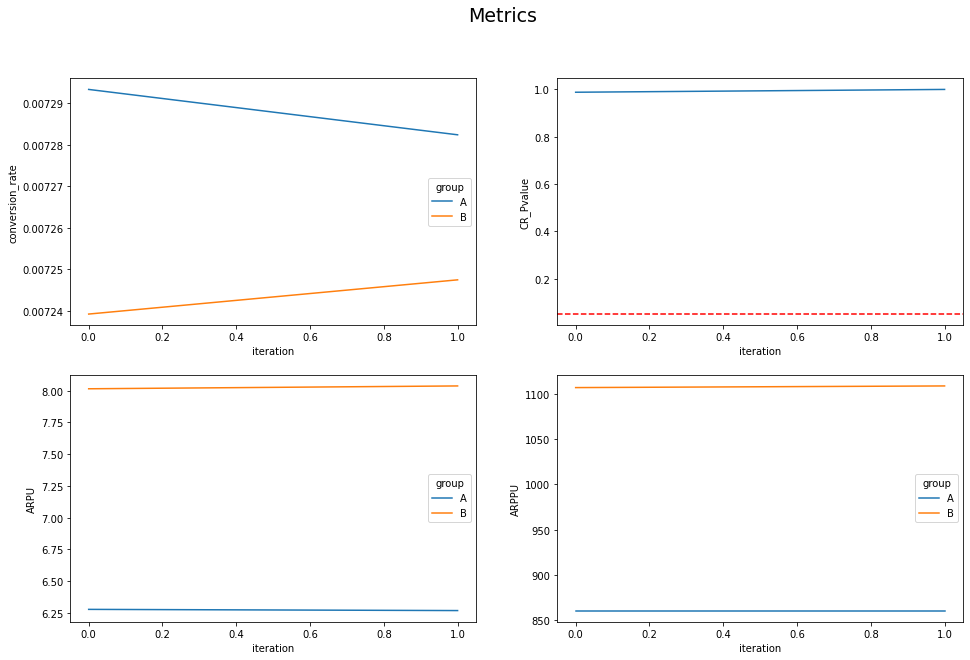

In [48]:
make_graphs(metrics)